In [4]:
# Import necessary libraries
import tensorflow as tf
from keras import layers, models
from keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime
import numpy as np
import random
import shutil

In [5]:
# Set my Sudent ID as random seed
STUDENT_ID = 409920 

# Set random seeds for reproducibility
tf.random.set_seed(STUDENT_ID)
np.random.seed(STUDENT_ID)

# Dataset parameters
IMG_SIZE_SMALL = 128  # Size for basic CNNs (Baseline, Deep Reg, Grayscale)
IMG_SIZE_VGG = 224    # Size required for VGG16
IMG_SIZE_SQUEEZE = 227  # Size for SqueezeNet
BATCH_SIZE = 32

# Define paths
dataset_path = 'dataset'

# Number of classes in the dataset
NUM_CLASSES = 3  # rock, paper, scissors

print("TensorFlow version:", tf.__version__)
print("Setup complete with student ID", STUDENT_ID, "as random seed")

TensorFlow version: 2.19.0
Setup complete with student ID 409920 as random seed


Total images in dataset: 2925

Split        Paper      Rock       Scissors   Total       
------------------------------------------------------------
train        683        683        683        2049         (70.1%)
validation   97         97         97         291          (9.9%)
test         195        195        195        585          (20.0%)


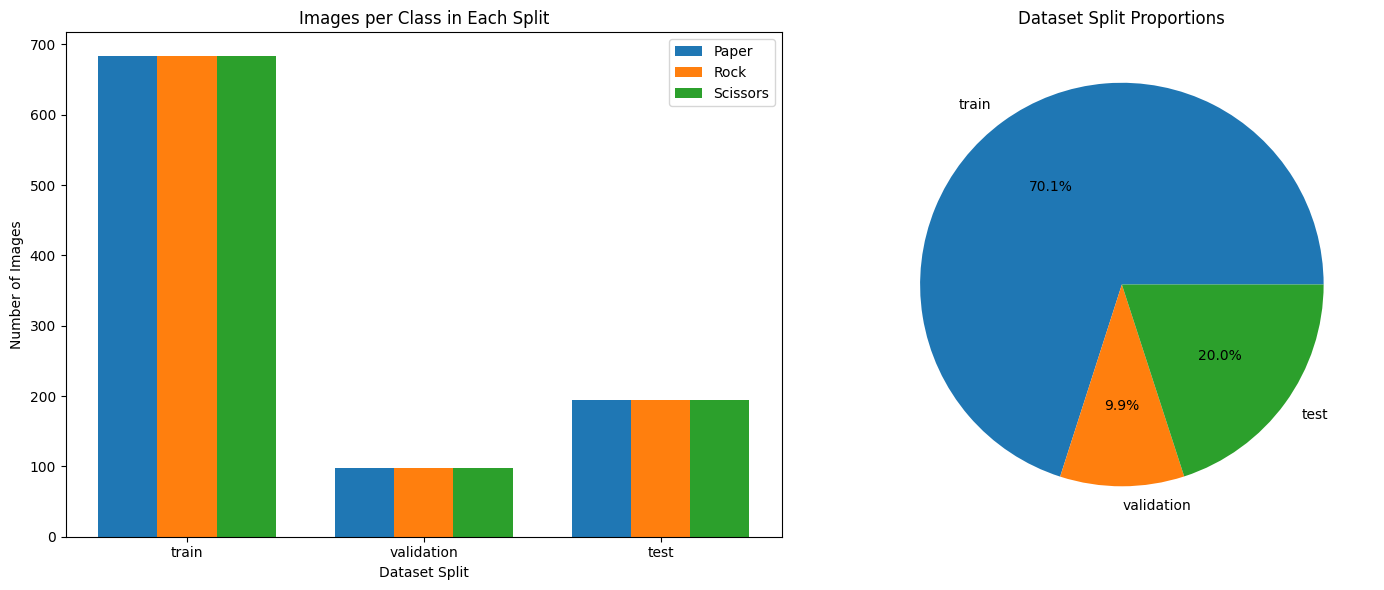


CLASS BALANCE WITHIN EACH SPLIT:
------------------------------------------------------------
TRAIN:
  Paper:    683 images (33.3%)
  Rock:     683 images (33.3%)
  Scissors: 683 images (33.3%)

VALIDATION:
  Paper:    97 images (33.3%)
  Rock:     97 images (33.3%)
  Scissors: 97 images (33.3%)

TEST:
  Paper:    195 images (33.3%)
  Rock:     195 images (33.3%)
  Scissors: 195 images (33.3%)



In [6]:
# Function to count images in a directory and its subdirectories
def count_images_in_directory(directory):
    class_counts = {}
    total_count = 0
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist!")
        return class_counts, total_count
    
    # Get all subdirectories (classes)
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    # If there are no subdirectories, count images directly in the directory
    if not class_dirs:
        image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        return {"no_class": len(image_files)}, len(image_files)
    
    # Count images in each class
    for class_name in class_dirs:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count = len(image_files)
        class_counts[class_name] = count
        total_count += count
    
    return class_counts, total_count

# Get counts for each split
dataset_root = 'dataset'
splits = ['train', 'validation', 'test']
all_counts = {}
total_images = 0

for split in splits:
    split_path = os.path.join(dataset_root, split)
    class_counts, split_total = count_images_in_directory(split_path)
    all_counts[split] = {
        'class_counts': class_counts,
        'total': split_total
    }
    total_images += split_total

# Print results in a formatted way
print(f"Total images in dataset: {total_images}\n")
print("{:<12} {:<10} {:<10} {:<10} {:<12}".format("Split", "Paper", "Rock", "Scissors", "Total"))
print("-" * 60)

for split in splits:
    counts = all_counts[split]['class_counts']
    split_total = all_counts[split]['total']
    
    # Get counts for each class (or 0 if class not present)
    paper_count = counts.get('paper', 0)
    rock_count = counts.get('rock', 0)
    scissors_count = counts.get('scissors', 0)
    
    # Calculate percentages of total dataset
    split_percent = (split_total / total_images) * 100
    
    print("{:<12} {:<10} {:<10} {:<10} {:<12} ({:.1f}%)".format(
        split, paper_count, rock_count, scissors_count, split_total, split_percent
    ))

# Create visualizations
plt.figure(figsize=(15, 6))

# Plot 1: Images per class in each split
plt.subplot(1, 2, 1)
width = 0.25
x = np.arange(len(splits))

# Extract counts for plotting
paper_counts = [all_counts[split]['class_counts'].get('paper', 0) for split in splits]
rock_counts = [all_counts[split]['class_counts'].get('rock', 0) for split in splits]
scissors_counts = [all_counts[split]['class_counts'].get('scissors', 0) for split in splits]

plt.bar(x - width, paper_counts, width, label='Paper')
plt.bar(x, rock_counts, width, label='Rock')
plt.bar(x + width, scissors_counts, width, label='Scissors')

plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Images per Class in Each Split')
plt.xticks(x, splits)
plt.legend()

# Plot 2: Split proportions
plt.subplot(1, 2, 2)
split_totals = [all_counts[split]['total'] for split in splits]
plt.pie(split_totals, labels=splits, autopct='%1.1f%%')
plt.title('Dataset Split Proportions')

plt.tight_layout()
plt.show()

print("\nCLASS BALANCE WITHIN EACH SPLIT:")
print("-" * 60)
for split in splits:
    counts = all_counts[split]['class_counts']
    split_total = all_counts[split]['total']
    
    # Get counts for each class (or 0 if class not present)
    paper_count = counts.get('paper', 0)
    rock_count = counts.get('rock', 0)
    scissors_count = counts.get('scissors', 0)
    
    # Calculate percentages within the split
    paper_percent = (paper_count / split_total) * 100 if split_total > 0 else 0
    rock_percent = (rock_count / split_total) * 100 if split_total > 0 else 0
    scissors_percent = (scissors_count / split_total) * 100 if split_total > 0 else 0
    
    print(f"{split.upper()}:")
    print(f"  Paper:    {paper_count} images ({paper_percent:.1f}%)")
    print(f"  Rock:     {rock_count} images ({rock_percent:.1f}%)")
    print(f"  Scissors: {scissors_count} images ({scissors_percent:.1f}%)")
    print()

In [7]:
# Set to False to prevent rebalancing
PERFORM_REBALANCING = False

# Set random seed for reproducibility
random.seed(STUDENT_ID)

def rebalance_dataset(dataset_path, source_split='train', target_splits=None, 
                      classes=['paper', 'rock', 'scissors']):
    """
    Rebalance the dataset by moving images from source_split to target_splits.
    
    Args:
        dataset_path: Path to the dataset root folder
        source_split: Folder to take images from (e.g., 'train')
        target_splits: Dictionary mapping target split names to images per class to move
        classes: List of class folders
    """
    if target_splits is None:
        return
    
    for class_name in classes:
        # Define source directory
        source_dir = os.path.join(dataset_path, source_split, class_name)
        
        # Get all image files in source directory
        image_files = [f for f in os.listdir(source_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Keep track of which images have been moved
        moved_images = []
        
        # Process each target split
        for target_split, images_per_class in target_splits.items():
            # Define target directory
            target_dir = os.path.join(dataset_path, target_split, class_name)
            
            # Create target directory if it doesn't exist
            os.makedirs(target_dir, exist_ok=True)
            
            # Get remaining images that haven't been moved yet
            remaining_images = [img for img in image_files if img not in moved_images]
            
            # Check if we have enough images to move
            if len(remaining_images) < images_per_class:
                print(f"Warning: Not enough images in {source_dir}. Found {len(remaining_images)}, need {images_per_class}")
                continue
                
            # Randomly select images to move
            images_to_move = random.sample(remaining_images, images_per_class)
            moved_images.extend(images_to_move)
            
            # Move selected images to target directory
            for image in images_to_move:
                source_file = os.path.join(source_dir, image)
                target_file = os.path.join(target_dir, image)
                shutil.move(source_file, target_file)
                print(f"Moved: {image} from {source_split}/{class_name} to {target_split}/{class_name}")
        
        total_moved = len(moved_images)
        print(f"Moved a total of {total_moved} images from {source_split}/{class_name}")

# Calculate proper amounts to move to achieve approximately 70/10/20 split
def calculate_moves_for_target_split(total_images=2925, current_splits=None):
    """
    Calculate how many images to move from train to validation and test
    to achieve approximately 70/10/20 split.
    """
    if current_splits is None:
        # Use your current distribution
        current_splits = {
            'train': 2520,
            'validation': 33,
            'test': 372
        }
    
    # Target numbers (based on 70/10/20 of total)
    target_train = int(total_images * 0.7)
    target_validation = int(total_images * 0.1)
    target_test = int(total_images * 0.2)
    
    # Calculate how many images to move from train
    to_validation = target_validation - current_splits['validation']
    to_test = target_test - current_splits['test']
    
    # Calculate per class (assuming 3 classes)
    to_validation_per_class = to_validation // 3
    to_test_per_class = to_test // 3
    
    print(f"To achieve 70/10/20 split:")
    print(f"  Move {to_validation_per_class} images per class from train to validation")
    print(f"  Move {to_test_per_class} images per class from train to test")
    
    return {
        'validation': to_validation_per_class,
        'test': to_test_per_class
    }

# Verify the distribution
def count_images(directory):
    """Count the number of images in each class directory."""
    class_counts = {}
    
    # Check if directory exists
    if not os.path.exists(directory):
        return class_counts
    
    # Get all subdirectories (classes)
    class_dirs = [d for d in os.listdir(directory) 
                  if os.path.isdir(os.path.join(directory, d))]
    
    # Count images in each class
    for class_name in class_dirs:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)
    
    return class_counts

# Count current distribution
dataset_path = 'dataset'

if PERFORM_REBALANCING:
    # This block contains the actual rebalancing code
    current_distribution = {}
    total_images = 0

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        current_distribution[split] = split_total
        total_images += split_total

    print("\nCURRENT DATASET DISTRIBUTION:")
    for split, count in current_distribution.items():
        print(f"  {split.capitalize()}: {count} images ({count/total_images*100:.1f}%)")

    # Calculate how many images to move
    moves = calculate_moves_for_target_split(total_images, current_distribution)

    # Run the rebalancing
    print("\nRebalancing dataset...")
    rebalance_dataset(dataset_path, 'train', moves)

    # Display the new counts
    print("\nNEW DATASET DISTRIBUTION:")
    new_distribution = {}
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        new_distribution[split] = split_total
        print(f"  {split.capitalize()} SET:")
        for class_name, count in counts.items():
            print(f"    {class_name}: {count} images")
        print(f"    Total: {split_total} images ({split_total/total_images*100:.1f}%)")

    print("\nRebalancing complete!")
else:
    # This block just shows information about the previous rebalancing
    print("REBALANCING SKIPPED - Dataset was previously rebalanced")
    print("To run rebalancing again, set PERFORM_REBALANCING = True (not recommended)")
    
    # Instead of rebalancing, just display the current distribution
    current_distribution = {}
    total_images = 0

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        current_distribution[split] = split_total
        total_images += split_total

    print("\nCURRENT DATASET DISTRIBUTION:")
    for split, count in current_distribution.items():
        print(f"  {split.capitalize()}: {count} images ({count/total_images*100:.1f}%)")
    
    print("\nClass distribution within each split:")
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        print(f"  {split.capitalize()} SET:")
        for class_name, count in sorted(counts.items()):
            print(f"    {class_name}: {count} images")

REBALANCING SKIPPED - Dataset was previously rebalanced
To run rebalancing again, set PERFORM_REBALANCING = True (not recommended)

CURRENT DATASET DISTRIBUTION:
  Train: 2049 images (70.1%)
  Validation: 291 images (9.9%)
  Test: 585 images (20.0%)

Class distribution within each split:
  Train SET:
    paper: 683 images
    rock: 683 images
    scissors: 683 images
  Validation SET:
    paper: 97 images
    rock: 97 images
    scissors: 97 images
  Test SET:
    paper: 195 images
    rock: 195 images
    scissors: 195 images


In [8]:
# Function to load and preprocess datasets
def load_dataset(split_path, img_size, grayscale=False, batch_size=BATCH_SIZE, augment=False):
    """
    Load and prepare a dataset with given parameters.
    
    Args:
        split_path: Path to dataset split folder (train, validation, or test)
        img_size: Target image size (height and width)
        grayscale: If True, convert images to grayscale
        batch_size: Number of images per batch
        augment: If True, apply data augmentation (for training only)
        
    Returns:
        Preprocessed TensorFlow dataset
    """
    # Load dataset from directory structure
    dataset = tf.keras.utils.image_dataset_from_directory(
        split_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        seed=STUDENT_ID  # Using student ID as seed for reproducibility
    )
    
    # Store class names before applying transformations
    class_names = dataset.class_names
    
    # Define preprocessing operations
    preprocessing_layers = []
    
    # Normalization layer (scale pixel values to 0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # Convert to grayscale if specified
    if grayscale:
        dataset = dataset.map(
            lambda x, y: (tf.image.rgb_to_grayscale(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Apply normalization
    dataset = dataset.map(
        lambda x, y: (normalization_layer(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply data augmentation if specified (only for training)
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1)
        ])
        
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Optimize pipeline with prefetching
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, class_names

In [10]:
# Function to visualize sample images from a dataset
def visualize_dataset_samples(dataset, class_names, title, grayscale=False, samples=9):
    """
    Visualize sample images from a dataset
    
    Args:
        dataset: TensorFlow dataset to visualize
        class_names: List of class names
        title: Plot title
        grayscale: If True, visualize as grayscale images
        samples: Number of samples to visualize
    """
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)
    
    # Get a batch of images from the dataset
    for images, labels in dataset.take(1):
        # Plot each image
        for i in range(min(samples, len(images))):
            plt.subplot(3, 3, i + 1)
            
            # Display image based on color mode
            if grayscale:
                plt.imshow(images[i, :, :, 0], cmap='gray')
            else:
                # Remove the uint8 conversion - directly display the normalized float values
                plt.imshow(images[i].numpy())
                
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

Loading RGB datasets (128x128)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.
Classes detected: ['paper', 'rock', 'scissors']
Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)
Image data type: <dtype: 'float32'>
Min pixel value: 0.04591335356235504
Max pixel value: 1.0
First few labels: [1 1 2 2 1]
Training dataset: 65 batches
Validation dataset: 10 batches
Test dataset: 19 batches
Approximate number of images:
  Training: ~2080 images
  Validation: ~320 images
  Test: ~608 images


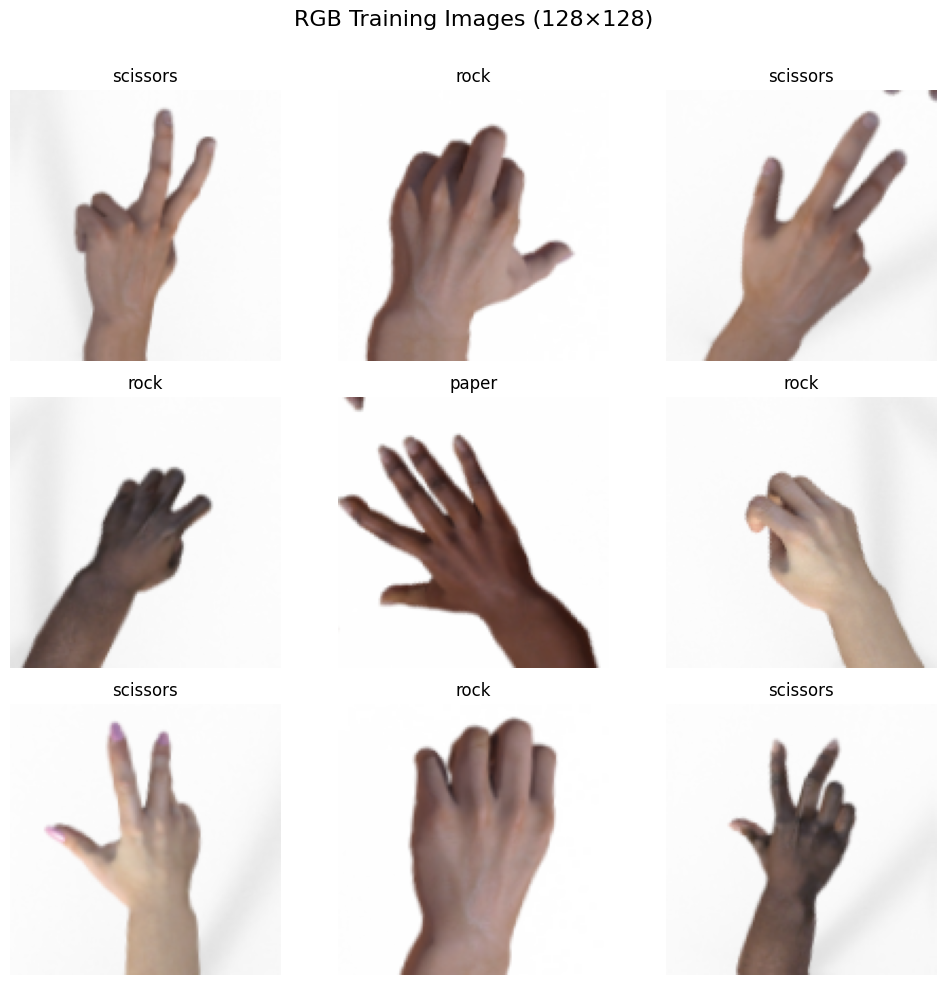

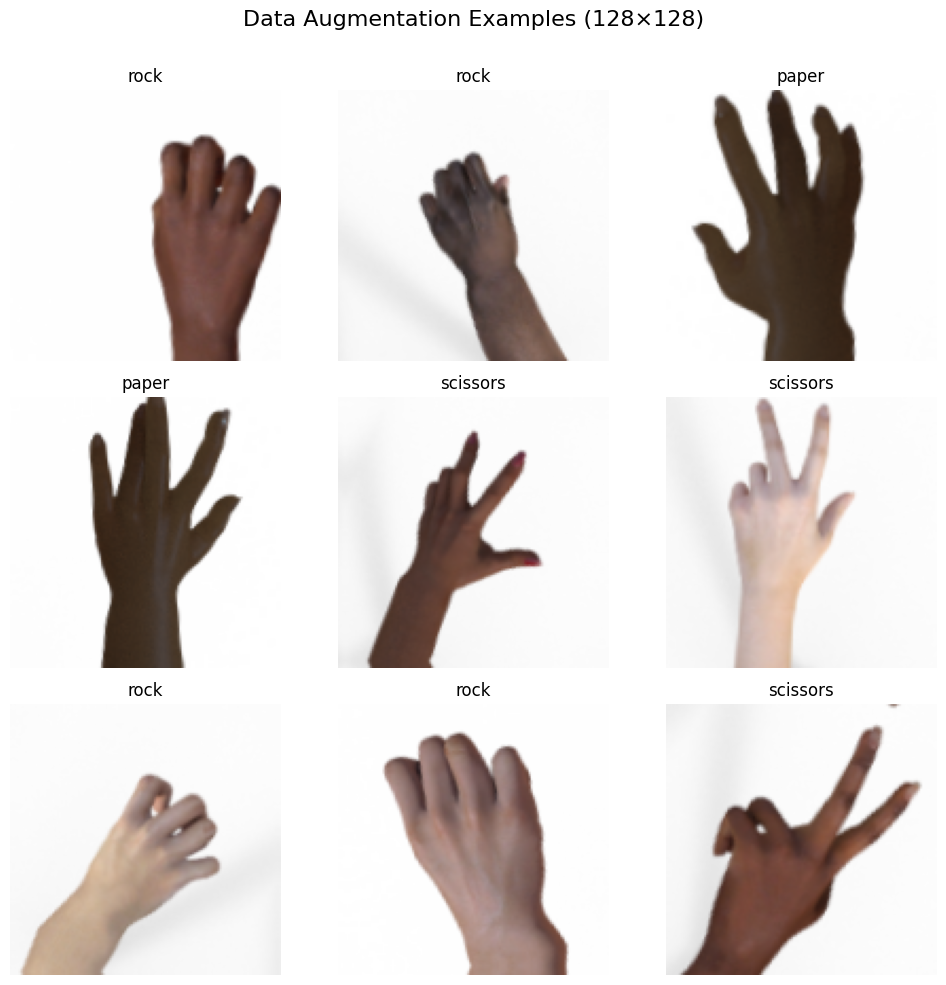

RGB dataset loading verified successfully!


In [20]:
# Load RGB datasets for Baseline and Deep Regularized CNN (128x128)
print("Loading RGB datasets (128x128)...")

# Training set with augmentation 
train_ds_small_rgb, train_class_names = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_SMALL, 
    grayscale=False, 
    augment=True
)

# Validation set (no augmentation)
val_ds_small_rgb, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_SMALL, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_small_rgb, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_SMALL, 
    grayscale=False
)

# Get class names from the dataset
class_names = train_class_names
print(f"Classes detected: {class_names}")

# Get the shape of the images and labels in the dataset
for images, labels in train_ds_small_rgb.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")
    print(f"First few labels: {labels[:5].numpy()}")

# Count number of batches in each dataset
print(f"Training dataset: {len(list(train_ds_small_rgb))} batches")
print(f"Validation dataset: {len(list(val_ds_small_rgb))} batches")
print(f"Test dataset: {len(list(test_ds_small_rgb))} batches")

# Estimate total number of images
train_images = len(list(train_ds_small_rgb)) * BATCH_SIZE
val_images = len(list(val_ds_small_rgb)) * BATCH_SIZE
test_images = len(list(test_ds_small_rgb)) * BATCH_SIZE
print(f"Approximate number of images:")
print(f"  Training: ~{train_images} images")
print(f"  Validation: ~{val_images} images")
print(f"  Test: ~{test_images} images")

# Visualize sample training images
visualize_dataset_samples(
    train_ds_small_rgb, 
    class_names, 
    title="RGB Training Images (128×128)"
)

# Visualize sample augmented images
# Run this cell multiple times to see different augmentations
plt.figure(figsize=(10, 10))
plt.suptitle("Data Augmentation Examples (128×128)", fontsize=16)

for images, labels in train_ds_small_rgb.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Use the same display approach as in the visualize_dataset_samples function
        # Don't convert to uint8, display the normalized float values directly
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print("RGB dataset loading verified successfully!")

## **Baseline CNN**

In [30]:
# Define the Baseline CNN model
def create_baseline_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3), num_classes=3):
    """
    Create a simple baseline CNN model with 3 convolutional layers
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [34]:
# Update the train_and_evaluate_model function to use .keras format
def train_and_evaluate_model(model, train_ds, val_ds, model_name, epochs=15):
    """
    Train and evaluate a model, measuring training time and inference speed
    
    Args:
        model: The model to train
        train_ds: Training dataset
        val_ds: Validation dataset
        model_name: Name for saving the model
        epochs: Number of training epochs
        
    Returns:
        Dictionary with training results and metrics
    """
    print(f"\n===== Training {model_name} =====")
    
    # Callbacks for training
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', 
            patience=5,
            restore_best_weights=True
        ),
        # Save best model (using .keras format instead of .h5)
        tf.keras.callbacks.ModelCheckpoint(
            f"{model_name}_best.keras",  # Changed from .h5 to .keras
            save_best_only=True,
            monitor="val_accuracy",
            mode="max"
        )
    ]
    
    # Measure training time
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    # Measure inference time (on validation set only)
    print("\nMeasuring inference time...")
    start_time = time.time()
    # Warmup
    for images, _ in val_ds.take(1):
        model.predict(images, verbose=0)
    
    # Actual inference time measurement
    batch_count = 0
    total_images = 0
    inference_start_time = time.time()
    
    for images, _ in val_ds:
        batch_count += 1
        total_images += images.shape[0]
        _ = model.predict(images, verbose=0)
    
    inference_time = time.time() - inference_start_time
    avg_inference_time_per_image = (inference_time / total_images) * 1000  # ms
    
    print(f"Average inference time: {avg_inference_time_per_image:.2f} ms per image")
    
    # Evaluate on validation set for model comparison
    print("\nEvaluating on validation set...")
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
    
    # Print summary results
    print(f"\n----- {model_name} Results -----")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {avg_inference_time_per_image:.2f} ms per image")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    # Return results
    results = {
        'model_name': model_name,
        'training_time': training_time,
        'inference_time_per_image': avg_inference_time_per_image,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history,
        'model': model
    }
    
    return results

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)


===== Training baseline_cnn =====
Epoch 1/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3970 - loss: 1.1909

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.3996 - loss: 1.1863 - val_accuracy: 0.8041 - val_loss: 0.5648
Epoch 2/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8053 - loss: 0.5297

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.8062 - loss: 0.5271 - val_accuracy: 0.9313 - val_loss: 0.1731
Epoch 3/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9189 - loss: 0.2615

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9191 - loss: 0.2606 - val_accuracy: 0.9863 - val_loss: 0.0530
Epoch 4/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9667 - loss: 0.1210

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.9666 - loss: 0.1212 - val_accuracy: 0.9897 - val_loss: 0.0340
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.9768 - loss: 0.0874 - val_accuracy: 0.9553 - val_loss: 0.0954
Epoch 6/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9740 - loss: 0.0947

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9739 - loss: 0.0947 - val_accuracy: 0.9931 - val_loss: 0.0248
Epoch 7/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9822 - loss: 0.0658

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9822 - loss: 0.0660 - val_accuracy: 0.9966 - val_loss: 0.0158
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9797 - loss: 0.0555 - val_accuracy: 0.9931 - val_loss: 0.0160
Epoch 9/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9858 - loss: 0.0420 - val_accuracy: 0.9966 - val_loss: 0.0080
Epoch 10/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9919 - loss: 0.0320 - val_accuracy: 0.9897 - val_loss: 0.0602
Epoch 11/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9812 - loss: 0.0489 - val_accuracy: 0.9931 - val_loss: 0.0169
Epoch 12/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9878 - loss: 0.0339 - val_accuracy: 0.9966 - val_loss: 0.0126

Training completed in 128.85 seconds

Measuring inference time...
Average inference time: 3.21 ms per image

Evaluating on validation set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9973 - loss: 0.0137

----- baseline_cn

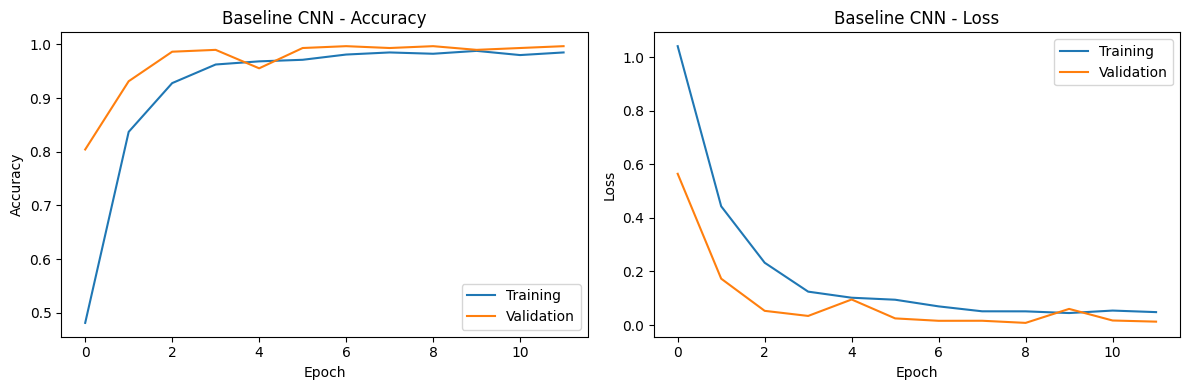

In [32]:
# Create the baseline model
baseline_model = create_baseline_cnn()
baseline_model.summary()

# Train and evaluate the model
baseline_results = train_and_evaluate_model(
    baseline_model,
    train_ds_small_rgb,
    val_ds_small_rgb,
    "baseline_cnn"
)

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_results['history'].history['accuracy'], label='Training')
plt.plot(baseline_results['history'].history['val_accuracy'], label='Validation')
plt.title('Baseline CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_results['history'].history['loss'], label='Training')
plt.plot(baseline_results['history'].history['val_loss'], label='Validation')
plt.title('Baseline CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Deep Regularised CNN**

In [35]:
# Define the Deep Regularized CNN model
def create_deep_reg_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3), num_classes=3):
    """
    Create a deeper CNN with regularization techniques (BatchNorm, Dropout)
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),  # Add dropout after conv block as specified
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  # Higher dropout rate in dense layers
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 8,679,459 (33.11 MB)

 Trainable params: 8,678,051 (33.10 MB)

 Non-trainable params: 1,408 (5.50 KB)


===== Training deep_reg_cnn =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 740ms/step - accuracy: 0.7746 - loss: 0.6538 - val_accuracy: 0.3333 - val_loss: 4.5877
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 48s 728ms/step - accuracy: 0.9686 - loss: 0.0934 - val_accuracy: 0.3333 - val_loss: 4.3988
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 738ms/step - accuracy: 0.9786 - loss: 0.0661 - val_accuracy: 0.3333 - val_loss: 6.8492
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 50s 763ms/step - accuracy: 0.9830 - loss: 0.0466 - val_accuracy: 0.6392 - val_loss: 4.5945
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 51s 777ms/step - accuracy: 0.9909 - loss: 0.0330 - val_accuracy: 0.5223 - val_loss: 2.5181
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 50s 759ms/step - accuracy: 0.9896 - loss: 0.0338 - val_accuracy: 0.5017 - val_loss: 1.6066
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 51s 778ms/step - accuracy: 0.9821 - loss: 0.0590 - val_accuracy: 0.9347 - val_loss: 0.1786
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 50s 764ms/step - accurac

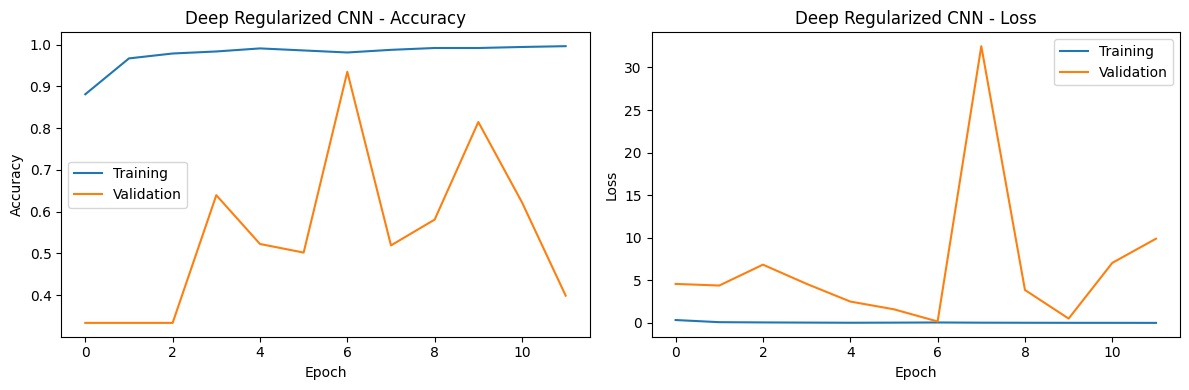

In [36]:
# Create and train the Deep Regularized CNN
deep_reg_model = create_deep_reg_cnn()
deep_reg_model.summary()

# Train and evaluate
deep_reg_results = train_and_evaluate_model(
    deep_reg_model,
    train_ds_small_rgb,
    val_ds_small_rgb,
    "deep_reg_cnn"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(deep_reg_results['history'].history['accuracy'], label='Training')
plt.plot(deep_reg_results['history'].history['val_accuracy'], label='Validation')
plt.title('Deep Regularized CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deep_reg_results['history'].history['loss'], label='Training')
plt.plot(deep_reg_results['history'].history['val_loss'], label='Validation')
plt.title('Deep Regularized CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Updated train_and_evaluate function to accept additional callbacks
def train_and_evaluate_model_with_callbacks(model, train_ds, val_ds, model_name, additional_callbacks=None, epochs=15):
    """
    Train and evaluate a model with additional callbacks
    
    Args:
        model: The model to train
        train_ds: Training dataset
        val_ds: Validation dataset
        model_name: Name for saving the model
        additional_callbacks: List of additional callbacks to use during training
        epochs: Number of training epochs
        
    Returns:
        Dictionary with training results and metrics
    """
    print(f"\n===== Training {model_name} =====")
    
    # Default callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', 
            patience=5,
            restore_best_weights=True
        ),
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            f"{model_name}_best.h5",
            save_best_only=True,
            monitor="val_accuracy",
            mode="max"
        )
    ]
    
    # Add additional callbacks if provided
    if additional_callbacks:
        if isinstance(additional_callbacks, list):
            callbacks.extend(additional_callbacks)
        else:
            callbacks.append(additional_callbacks)
    
    # Measure training time
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    # Measure inference time (on validation set only)
    print("\nMeasuring inference time...")
    start_time = time.time()
    # Warmup
    for images, _ in val_ds.take(1):
        model.predict(images, verbose=0)
    
    # Actual inference time measurement
    batch_count = 0
    total_images = 0
    inference_start_time = time.time()
    
    for images, _ in val_ds:
        batch_count += 1
        total_images += images.shape[0]
        _ = model.predict(images, verbose=0)
    
    inference_time = time.time() - inference_start_time
    avg_inference_time_per_image = (inference_time / total_images) * 1000  # ms
    
    print(f"Average inference time: {avg_inference_time_per_image:.2f} ms per image")
    
    # Evaluate on validation set for model comparison
    print("\nEvaluating on validation set...")
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
    
    # Print summary results
    print(f"\n----- {model_name} Results -----")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {avg_inference_time_per_image:.2f} ms per image")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    # Return results
    results = {
        'model_name': model_name,
        'training_time': training_time,
        'inference_time_per_image': avg_inference_time_per_image,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history,
        'model': model
    }
    
    return results

In [38]:
# Define the Improved Deep Regularized CNN model
def create_improved_deep_reg_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3), num_classes=3):
    """
    Create an improved deeper CNN with better balanced regularization
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block - simplified to single conv + batchnorm
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),  # Reduced dropout rate
        
        # Fourth convolutional block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  # Reduced dropout rate
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Create learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    
    # Use lower initial learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, lr_scheduler



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,586,691 (17.50 MB)

 Trainable params: 4,585,219 (17.49 MB)

 Non-trainable params: 1,472 (5.75 KB)


===== Training improved_deep_reg_cnn =====
Epoch 1/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7139 - loss: 0.7299

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - accuracy: 0.7179 - loss: 0.7204 - val_accuracy: 0.3333 - val_loss: 2.4913 - learning_rate: 1.0000e-04
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9620 - loss: 0.1203 - val_accuracy: 0.3333 - val_loss: 4.4215 - learning_rate: 1.0000e-04
Epoch 3/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9802 - loss: 0.0603


Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9803 - loss: 0.0603 - val_accuracy: 0.3780 - val_loss: 5.3073 - learning_rate: 1.0000e-04
Epoch 4/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9914 - loss: 0.0360

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9913 - loss: 0.0361 - val_accuracy: 0.5292 - val_loss: 5.4164 - learning_rate: 5.0000e-05
Epoch 5/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9892 - loss: 0.0337
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 365ms/step - accuracy: 0.9893 - loss: 0.0337 - val_accuracy: 0.5086 - val_loss: 4.6714 - learning_rate: 5.0000e-05
Epoch 6/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9902 - loss: 0.0285

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.9903 - loss: 0.0284 - val_accuracy: 0.5395 - val_loss: 3.2592 - learning_rate: 2.5000e-05
Epoch 7/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9905 - loss: 0.0291

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.9905 - loss: 0.0290 - val_accuracy: 0.5911 - val_loss: 2.0056 - learning_rate: 2.5000e-05
Epoch 8/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9953 - loss: 0.0234

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.9953 - loss: 0.0233 - val_accuracy: 0.8110 - val_loss: 0.5763 - learning_rate: 2.5000e-05
Epoch 9/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9948 - loss: 0.0205

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 375ms/step - accuracy: 0.9948 - loss: 0.0205 - val_accuracy: 0.9656 - val_loss: 0.1174 - learning_rate: 2.5000e-05
Epoch 10/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9949 - loss: 0.0190

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 376ms/step - accuracy: 0.9949 - loss: 0.0189 - val_accuracy: 0.9863 - val_loss: 0.0378 - learning_rate: 2.5000e-05
Epoch 11/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9925 - loss: 0.0223

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9926 - loss: 0.0223 - val_accuracy: 0.9931 - val_loss: 0.0223 - learning_rate: 2.5000e-05
Epoch 12/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9923 - loss: 0.0265

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.9923 - loss: 0.0264 - val_accuracy: 0.9966 - val_loss: 0.0342 - learning_rate: 2.5000e-05
Epoch 13/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9970 - loss: 0.0143 - val_accuracy: 0.9897 - val_loss: 0.0214 - learning_rate: 2.5000e-05
Epoch 14/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 380ms/step - accuracy: 0.9966 - loss: 0.0122 - val_accuracy: 0.9897 - val_loss: 0.0339 - learning_rate: 2.5000e-05
Epoch 15/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9963 - loss: 0.0124
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 382ms/step - accuracy: 0.9963 - loss: 0.0124 - val_accuracy: 0.9656 - val_loss: 0.0803 - learning_rate: 2.5000e-05

Training completed in 373.49 seconds

Measuring inference time...
Average inference time: 4.43 ms per image

Evaluating on validation set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9956 - loss: 0.0381

----- impro

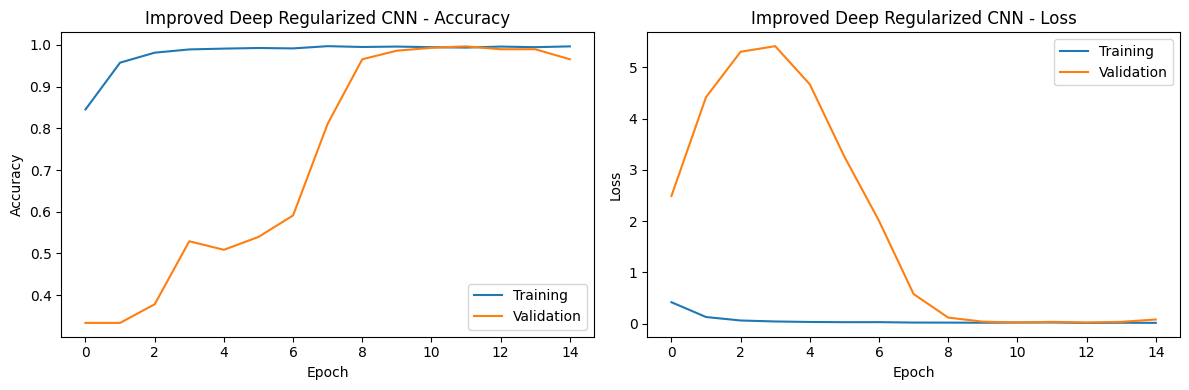

In [39]:
# Create and train the Improved Deep Regularized CNN
improved_model, lr_scheduler = create_improved_deep_reg_cnn()
improved_model.summary()

# Train and evaluate with learning rate scheduler
improved_reg_results = train_and_evaluate_model_with_callbacks(
    improved_model,
    train_ds_small_rgb,
    val_ds_small_rgb,
    "improved_deep_reg_cnn",
    additional_callbacks=lr_scheduler
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(improved_reg_results['history'].history['accuracy'], label='Training')
plt.plot(improved_reg_results['history'].history['val_accuracy'], label='Validation')
plt.title('Improved Deep Regularized CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(improved_reg_results['history'].history['loss'], label='Training')
plt.plot(improved_reg_results['history'].history['val_loss'], label='Validation')
plt.title('Improved Deep Regularized CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Greyscale**

Loading grayscale datasets (128x128)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


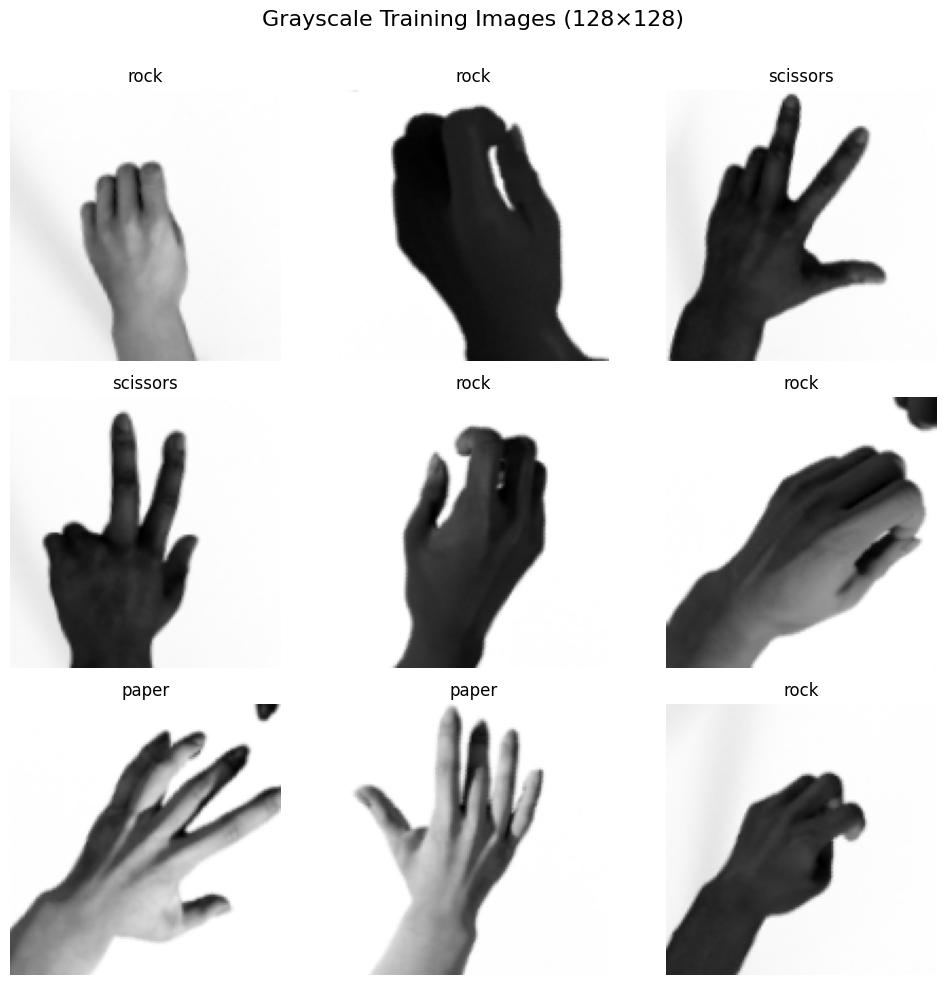

In [40]:
# Load grayscale datasets
print("Loading grayscale datasets (128x128)...")

# Training set with augmentation
train_ds_small_gray, train_class_names_gray = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_SMALL, 
    grayscale=True,  # Convert to grayscale
    augment=True
)

# Validation set (no augmentation)
val_ds_small_gray, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_SMALL, 
    grayscale=True
)

# Test set (no augmentation)
test_ds_small_gray, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_SMALL, 
    grayscale=True
)

# Visualize a few grayscale images
visualize_dataset_samples(
    train_ds_small_gray, 
    train_class_names_gray, 
    title="Grayscale Training Images (128×128)",
    grayscale=True
)

In [41]:
# Define the Grayscale CNN model
def create_grayscale_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 1), num_classes=3):
    """
    Create a CNN model for grayscale images
    
    Args:
        input_shape: Shape of input images (with 1 channel for grayscale)
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,387 (16.36 MB)

 Trainable params: 4,287,939 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)


===== Training grayscale_cnn =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.4912 - loss: 5.9450 - val_accuracy: 0.6082 - val_loss: 4.8375
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.7438 - loss: 0.6380 - val_accuracy: 0.5361 - val_loss: 9.5161
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.7838 - loss: 0.5139 - val_accuracy: 0.6357 - val_loss: 8.0501
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.8139 - loss: 0.5670 - val_accuracy: 0.4021 - val_loss: 6.0262
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step - accuracy: 0.8863 - loss: 0.3665 - val_accuracy: 0.6564 - val_loss: 3.4499
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 329ms/step - accuracy: 0.9003 - loss: 0.3020 - val_accuracy: 0.5361 - val_loss: 3.3785
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - accuracy: 0.7952 - loss: 0.6490 - val_accuracy: 0.4467 - val_loss: 2.4865
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accura

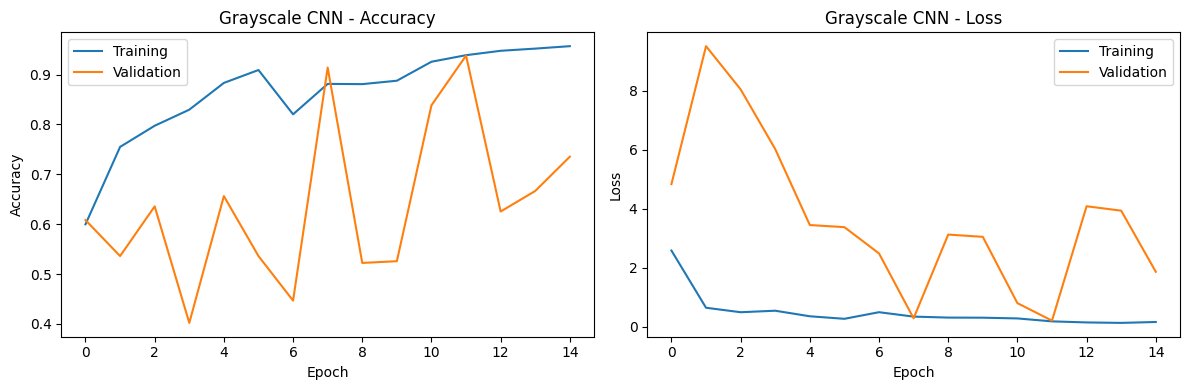

In [42]:
# Create and train the Grayscale CNN
grayscale_model = create_grayscale_cnn()
grayscale_model.summary()

# Train and evaluate the model
grayscale_results = train_and_evaluate_model(
    grayscale_model,
    train_ds_small_gray,
    val_ds_small_gray,
    "grayscale_cnn"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(grayscale_results['history'].history['accuracy'], label='Training')
plt.plot(grayscale_results['history'].history['val_accuracy'], label='Validation')
plt.title('Grayscale CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grayscale_results['history'].history['loss'], label='Training')
plt.plot(grayscale_results['history'].history['val_loss'], label='Validation')
plt.title('Grayscale CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **VGG-16 Transfer Learning Model**

Loading datasets for VGG-16 transfer learning (224x224)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


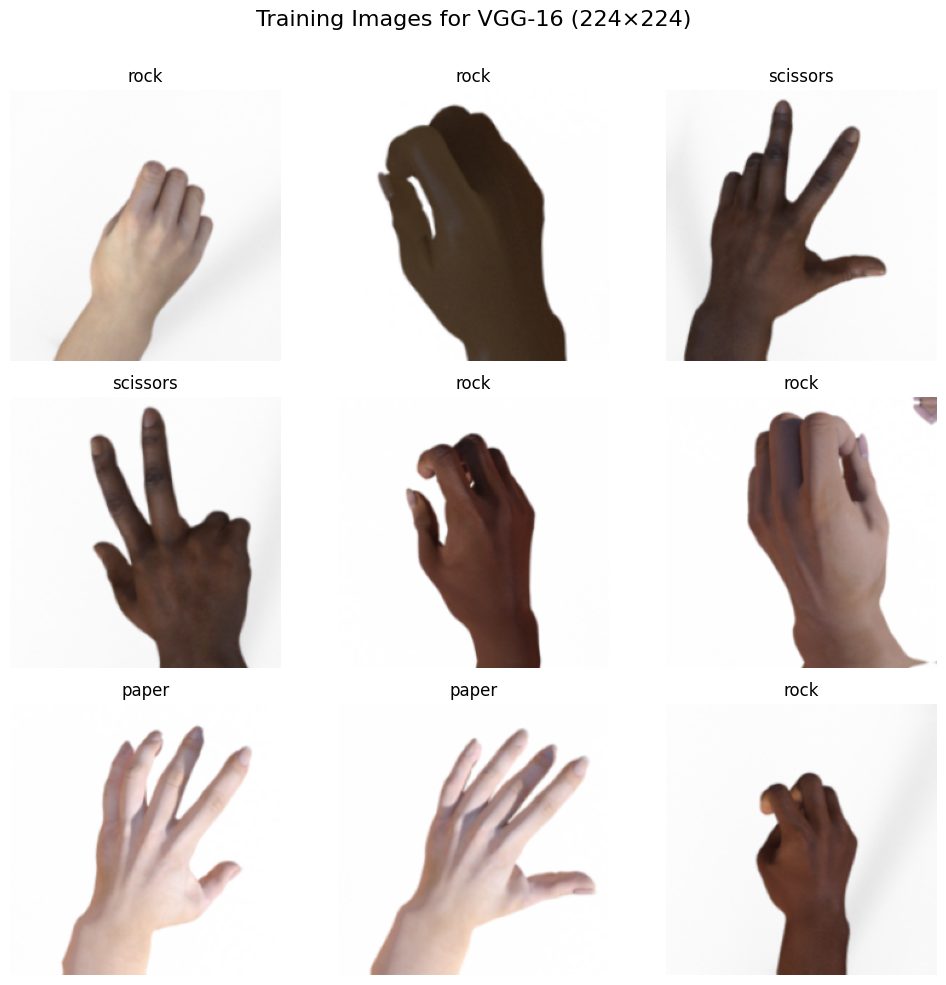

In [13]:
# Load datasets for VGG-16 (224x224)
print("Loading datasets for VGG-16 transfer learning (224x224)...")

# Training set with augmentation
train_ds_vgg, train_class_names_vgg = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_VGG,  # 224x224 for VGG-16
    grayscale=False,  # VGG-16 requires RGB
    augment=True
)

# Validation set (no augmentation)
val_ds_vgg, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_vgg, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Visualize a few VGG-sized images
visualize_dataset_samples(
    train_ds_vgg, 
    train_class_names_vgg, 
    title="Training Images for VGG-16 (224×224)"
)

In [44]:
# Import VGG16 model
from keras.applications import VGG16

# Define VGG-16 Transfer Learning Model
def create_vgg16_transfer_learning(input_shape=(IMG_SIZE_VGG, IMG_SIZE_VGG, 3), num_classes=3):
    """
    Create a transfer learning model using VGG-16 as the base
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    # Load pre-trained VGG-16 model without the top classification layers
    base_model = VGG16(
        weights='imagenet',  # Pre-trained on ImageNet
        include_top=False,   # Exclude the top fully connected layers
        input_shape=input_shape
    )
    
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Create a new model on top
    model = tf.keras.Sequential([
        # The pre-trained base model
        base_model,
        
        # Add new classification head
        tf.keras.layers.GlobalAveragePooling2D(),  # Global pooling
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


===== Training vgg16_transfer_learning =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.5388 - loss: 0.9698 - val_accuracy: 0.9381 - val_loss: 0.3857
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9274 - loss: 0.3196 - val_accuracy: 0.9553 - val_loss: 0.1879
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9710 - loss: 0.1517 - val_accuracy: 0.9897 - val_loss: 0.0945
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9864 - loss: 0.1005 - val_accuracy: 0.9863 - val_loss: 0.0690
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9878 - loss: 0.0656 - val_accuracy: 0.9897 - val_loss: 0.0480
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9931 - loss: 0.0445 - val_accuracy: 0.9966 - val_loss: 0.0349
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9904 - loss: 0.0375 - val_accuracy: 0.9966 - val_loss: 0.0335
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.

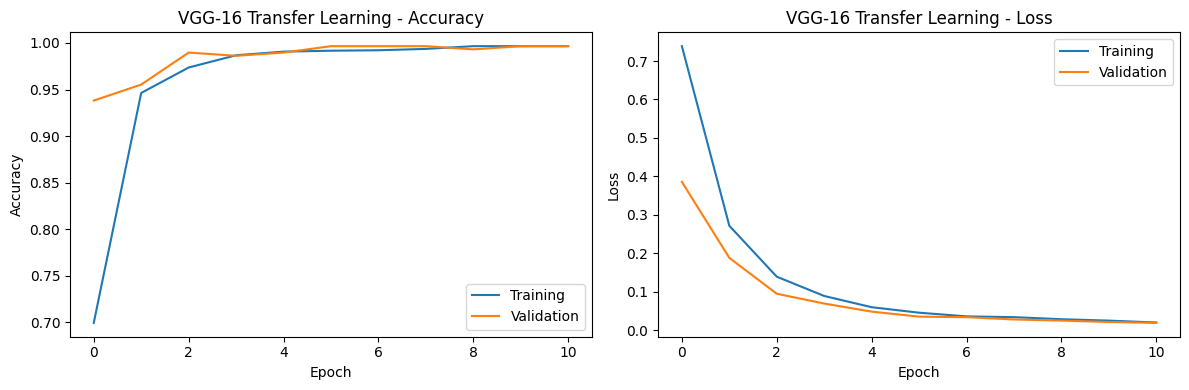

In [45]:
# Create and display the VGG-16 transfer learning model
vgg16_model = create_vgg16_transfer_learning()
vgg16_model.summary()

# Train and evaluate the model
vgg16_results = train_and_evaluate_model(
    vgg16_model,
    train_ds_vgg,
    val_ds_vgg,
    "vgg16_transfer_learning"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_results['history'].history['accuracy'], label='Training')
plt.plot(vgg16_results['history'].history['val_accuracy'], label='Validation')
plt.title('VGG-16 Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_results['history'].history['loss'], label='Training')
plt.plot(vgg16_results['history'].history['val_loss'], label='Validation')
plt.title('VGG-16 Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
# Load best pre-trained model
from keras.models import load_model
vgg16_model = load_model("vgg16_transfer_learning_best.keras")

# Unfreeze top layers of VGG16 base
base_model = vgg16_model.layers[0]
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with low learning rate
from keras.optimizers import Adam
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
def train_and_evaluate_model_finetune(model, train_ds, val_ds, model_name, epochs=2):
    print(f"\n===== Fine-tuning {model_name} =====")
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}_best.keras", save_best_only=True)
    ]
    
    start_time = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    start_time = time.time()
    total_images = 0
    for images, _ in val_ds:
        total_images += images.shape[0]
        _ = model.predict(images, verbose=0)
    inference_time = time.time() - start_time
    avg_inference_time = (inference_time / total_images) * 1000
    print(f"Inference time: {avg_inference_time:.2f} ms per image")
    
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
    print(f"\n----- {model_name} Results -----")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {avg_inference_time:.2f} ms per image")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    return {
        'model_name': model_name,
        'training_time': training_time,
        'inference_time_per_image': avg_inference_time,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history,
        'model': model
    }


===== Fine-tuning vgg16_finetuned =====
Epoch 1/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9966 - loss: 0.0294 - val_accuracy: 0.9966 - val_loss: 0.0127
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9984 - loss: 0.0053 - val_accuracy: 0.9966 - val_loss: 0.0199

Training completed in 361.48 seconds
Inference time: 67.38 ms per image
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9978 - loss: 0.0103

----- vgg16_finetuned Results -----
Training time: 361.48 seconds
Inference time: 67.38 ms per image
Validation accuracy: 0.9966
Validation loss: 0.0127


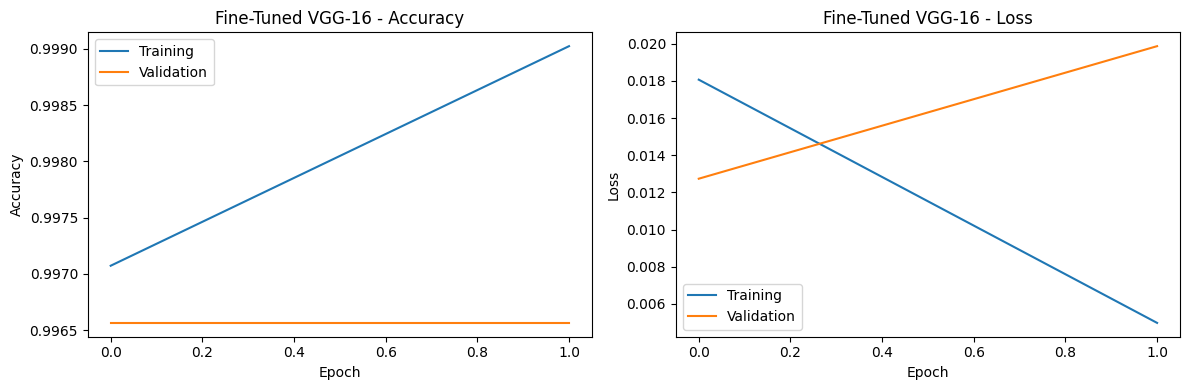

In [14]:
vgg16_finetune_results = train_and_evaluate_model_finetune(
    vgg16_model,
    train_ds_vgg,
    val_ds_vgg,
    "vgg16_finetuned"
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_finetune_results['history'].history['accuracy'], label='Training')
plt.plot(vgg16_finetune_results['history'].history['val_accuracy'], label='Validation')
plt.title('Fine-Tuned VGG-16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_finetune_results['history'].history['loss'], label='Training')
plt.plot(vgg16_finetune_results['history'].history['val_loss'], label='Validation')
plt.title('Fine-Tuned VGG-16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **ResNet**

Loading datasets for ResNet transfer learning (224x224)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


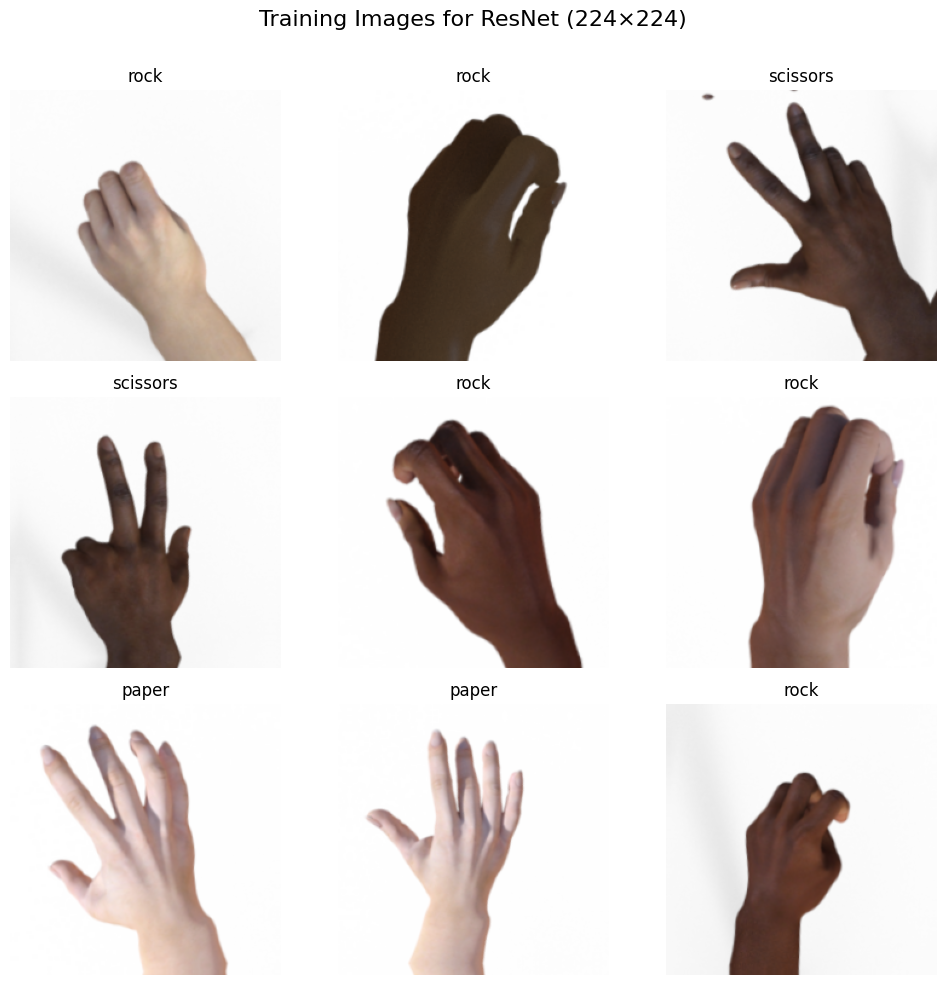

In [49]:
# Load datasets for ResNet (224x224)
print("Loading datasets for ResNet transfer learning (224x224)...")

# Training set with augmentation
train_ds_resnet, train_class_names_resnet = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_VGG,  # 224x224 for ResNet (same as VGG)
    grayscale=False,  # ResNet requires RGB
    augment=True
)

# Validation set (no augmentation)
val_ds_resnet, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_resnet, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Visualize a few ResNet-sized images
visualize_dataset_samples(
    train_ds_resnet, 
    train_class_names_resnet, 
    title="Training Images for ResNet (224×224)"
)

In [50]:
from keras.applications import ResNet50

# Define the ResNet transfer learning model
def create_resnet_transfer_learning(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a ResNet-50 transfer learning model with pre-trained weights
    """
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',  # Pre-trained weights
        include_top=False,   # Exclude classification layer
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create a new model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


===== Training resnet_transfer_learning =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4259 - loss: 1.2525 - val_accuracy: 0.5773 - val_loss: 0.8910
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5535 - loss: 0.9222 - val_accuracy: 0.7079 - val_loss: 0.7901
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 66s 996ms/step - accuracy: 0.6188 - loss: 0.8481 - val_accuracy: 0.6735 - val_loss: 0.7526
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6605 - loss: 0.7915 - val_accuracy: 0.7938 - val_loss: 0.6543
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7530 - loss: 0.6681 - val_accuracy: 0.8522 - val_loss: 0.5324
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7439 - loss: 0.6283 - val_accuracy: 0.9107 - val_loss: 0.4528
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 66s 998ms/step - accuracy: 0.7999 - loss: 0.5286 - val_accuracy: 0.8729 - val_loss: 0.4544
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8

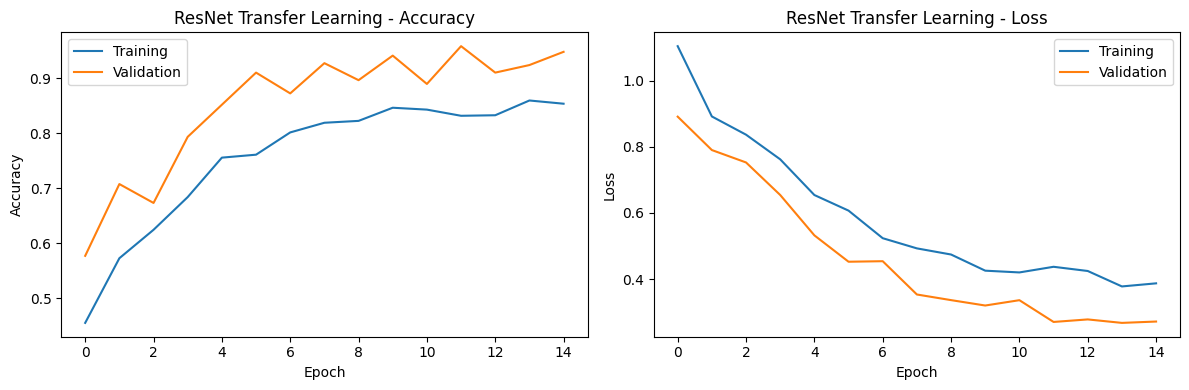

In [53]:
# Create and train the ResNet model
resnet_model = create_resnet_transfer_learning()
resnet_model.summary()

# Train and evaluate the model
resnet_results = train_and_evaluate_model(
    resnet_model,
    train_ds_resnet,
    val_ds_resnet,
    "resnet_transfer_learning"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resnet_results['history'].history['accuracy'], label='Training')
plt.plot(resnet_results['history'].history['val_accuracy'], label='Validation')
plt.title('ResNet Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_results['history'].history['loss'], label='Training')
plt.plot(resnet_results['history'].history['val_loss'], label='Validation')
plt.title('ResNet Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Analyzing model misclassifications on validation set...

=== Misclassification Analysis for Baseline CNN ===
Overall accuracy: 0.9966
Total misclassifications: 1 out of 291 images


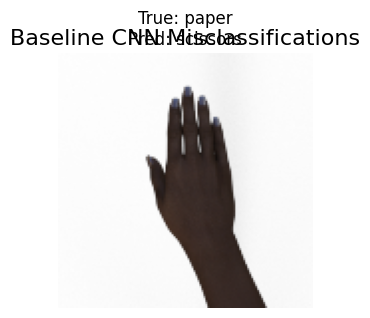

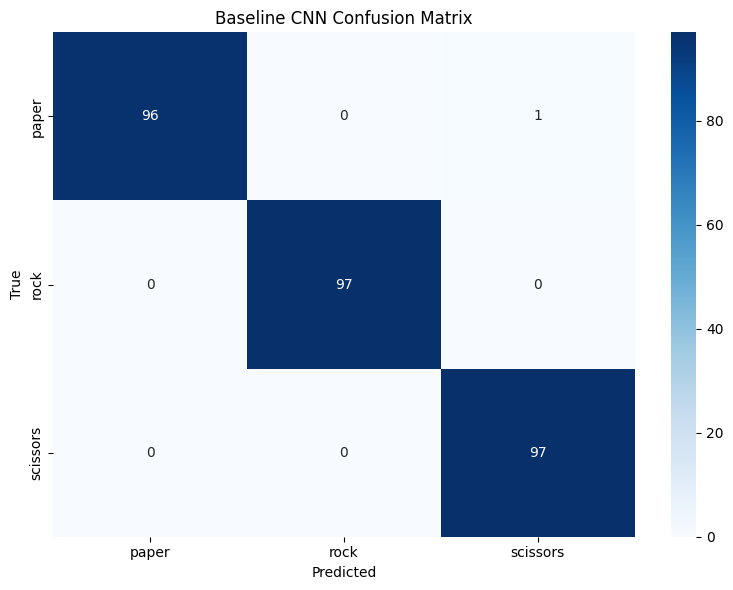


=== Misclassification Analysis for Improved Deep Regularized CNN ===
Overall accuracy: 0.9966
Total misclassifications: 1 out of 291 images


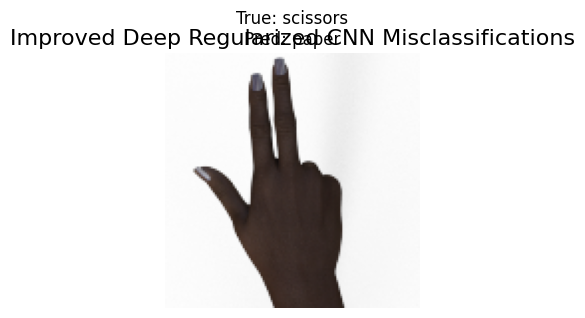

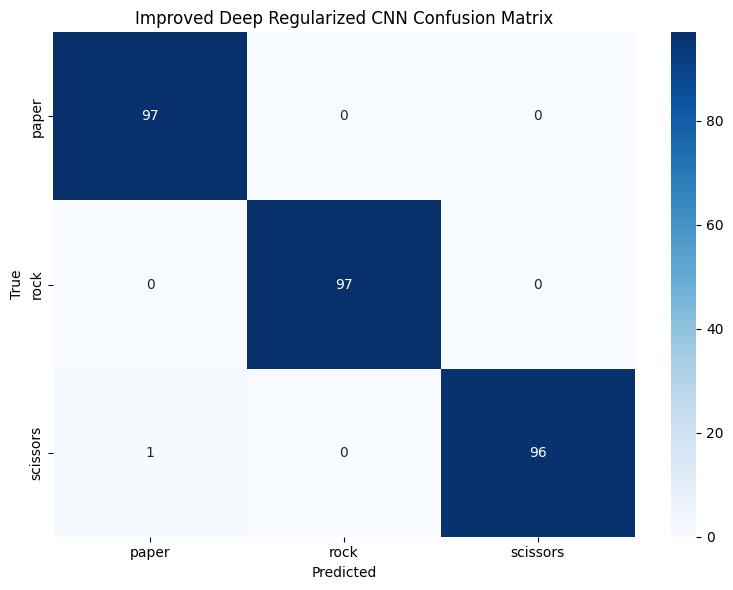


=== Misclassification Analysis for Grayscale CNN ===
Overall accuracy: 0.9381
Total misclassifications: 18 out of 291 images


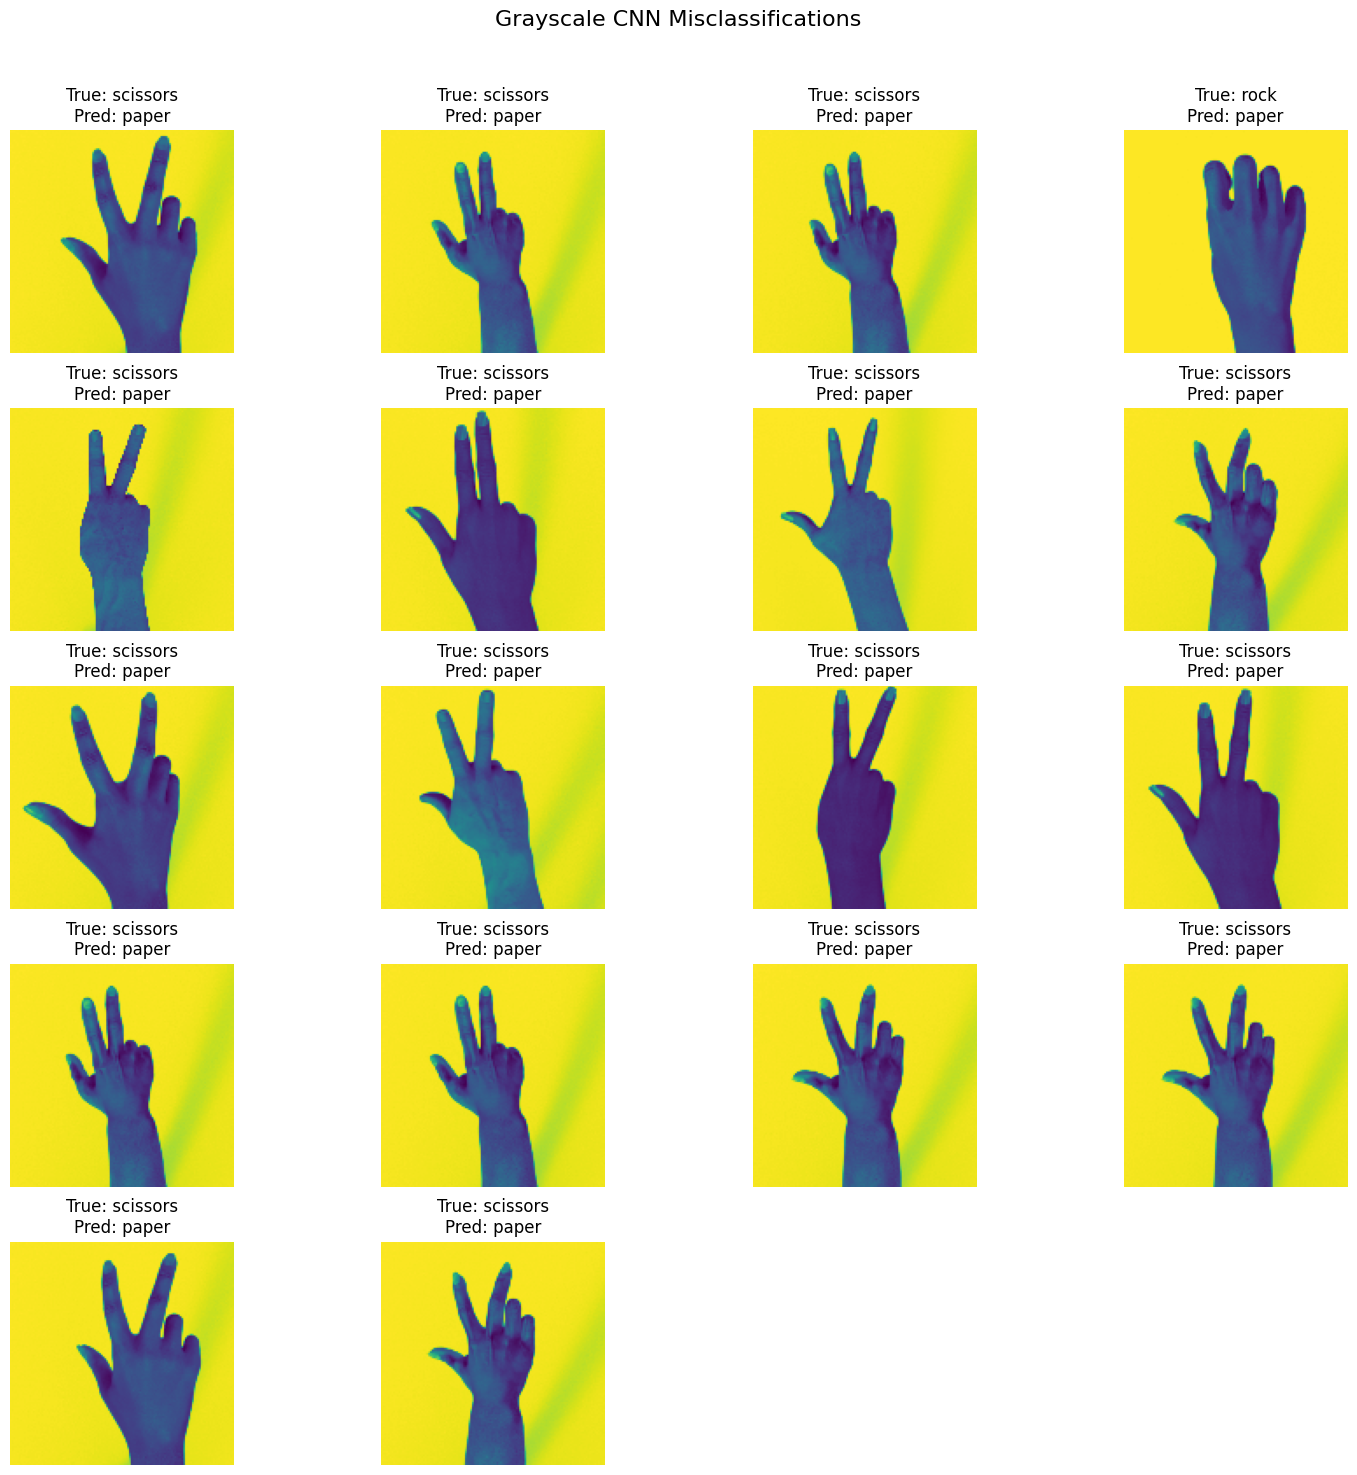

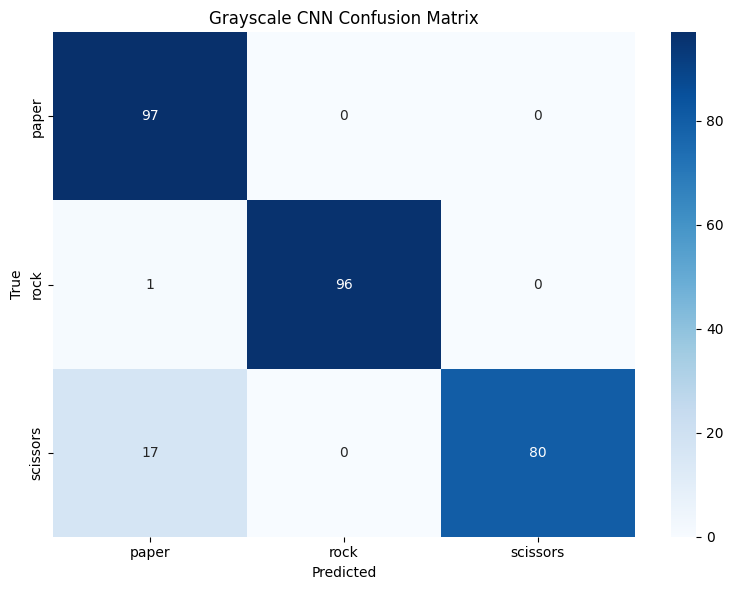


=== Misclassification Analysis for VGG-16 Transfer Learning ===
Overall accuracy: 0.9966
Total misclassifications: 1 out of 291 images


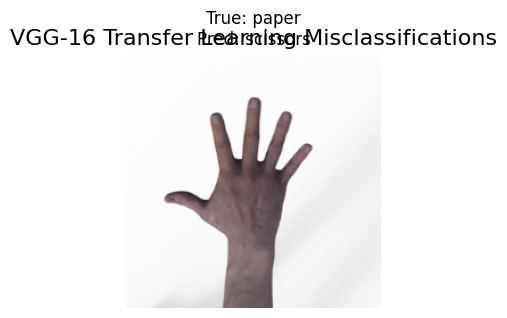

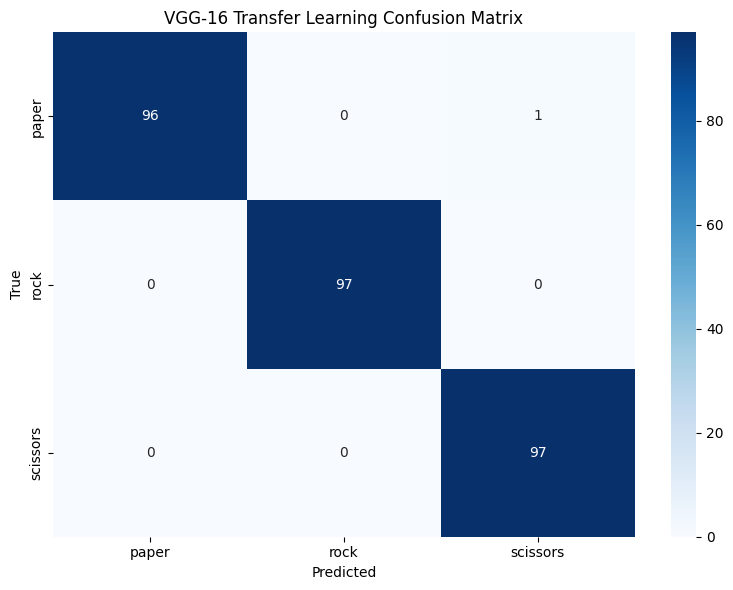


=== Misclassification Analysis for ResNet Transfer Learning ===
Overall accuracy: 0.9588
Total misclassifications: 12 out of 291 images


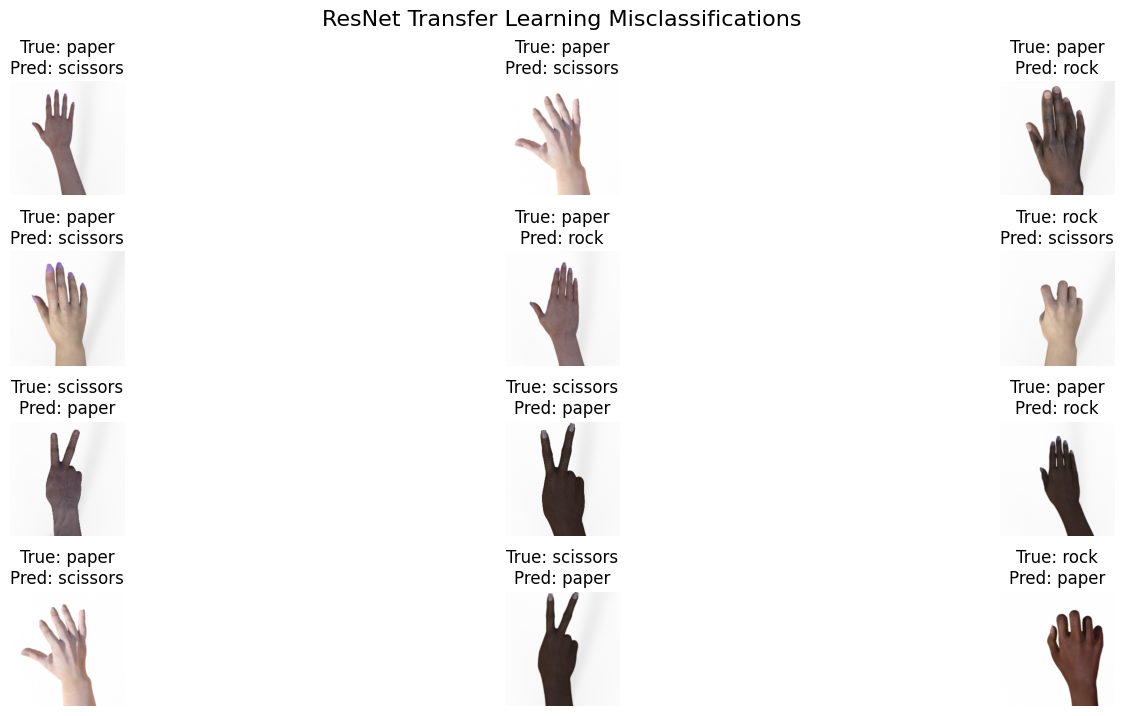

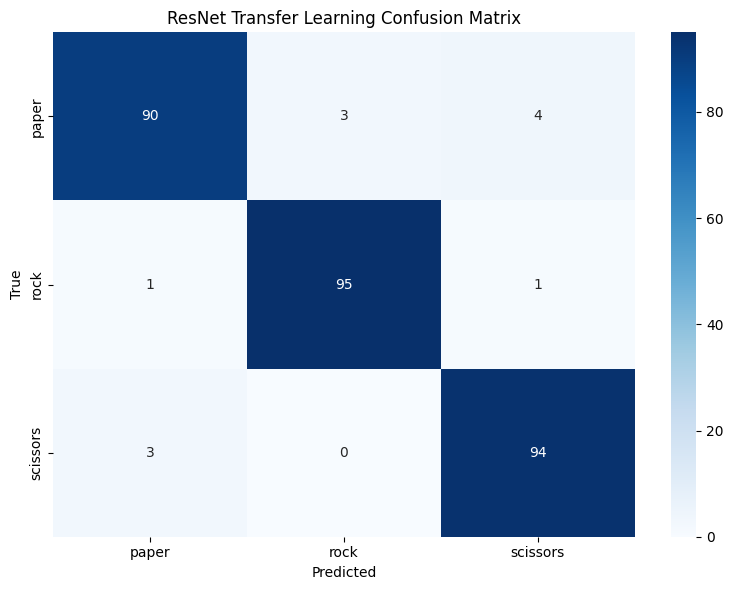


=== Common Misclassification Patterns ===

Baseline CNN misclassification patterns:
Frequently misclassified true classes:
  paper: 1 instances
Common prediction errors:
  paper → scissors: 1 instances

Improved Deep Reg CNN misclassification patterns:
Frequently misclassified true classes:
  scissors: 1 instances
Common prediction errors:
  scissors → paper: 1 instances

Grayscale CNN misclassification patterns:
Frequently misclassified true classes:
  scissors: 17 instances
  rock: 1 instances
Common prediction errors:
  scissors → paper: 17 instances
  rock → paper: 1 instances

VGG-16 misclassification patterns:
Frequently misclassified true classes:
  paper: 1 instances
Common prediction errors:
  paper → scissors: 1 instances

ResNet misclassification patterns:
Frequently misclassified true classes:
  paper: 7 instances
  scissors: 3 instances
  rock: 2 instances
Common prediction errors:
  paper → scissors: 4 instances
  paper → rock: 3 instances
  scissors → paper: 3 instances

In [54]:
# Function to analyze misclassifications
def analyze_misclassifications(model, dataset, class_names, model_name):
    """
    Analyze misclassified images from a model
    
    Args:
        model: Trained model to evaluate
        dataset: Dataset to check for misclassifications
        class_names: List of class names
        model_name: Name of the model for display purposes
        
    Returns:
        misclassified_examples: List of tuples (image, true_label, predicted_label)
    """
    print(f"\n=== Misclassification Analysis for {model_name} ===")
    
    # Lists to store misclassified examples
    misclassified_examples = []
    misclassified_indices = []
    all_predictions = []
    all_true_labels = []
    
    # Process each batch
    batch_index = 0
    for images, labels in dataset:
        # Get predictions
        predictions = model.predict(images, verbose=0)
        predicted_classes = tf.argmax(predictions, axis=1).numpy()
        
        # Find misclassifications in this batch
        for i in range(len(images)):
            true_label = labels[i].numpy()
            pred_label = predicted_classes[i]
            all_predictions.append(pred_label)
            all_true_labels.append(true_label)
            
            if true_label != pred_label:
                misclassified_examples.append((
                    images[i].numpy(),
                    true_label,
                    pred_label
                ))
                misclassified_indices.append((batch_index, i))
        
        batch_index += 1
    
    # Calculate accuracy
    accuracy = sum(p == t for p, t in zip(all_predictions, all_true_labels)) / len(all_predictions)
    print(f"Overall accuracy: {accuracy:.4f}")
    print(f"Total misclassifications: {len(misclassified_examples)} out of {len(all_predictions)} images")
    
    # Display misclassified examples
    if len(misclassified_examples) > 0:
        plt.figure(figsize=(15, min(15, 3 * ((len(misclassified_examples) + 3) // 4))))
        for i, (img, true_label, pred_label) in enumerate(misclassified_examples):
            plt.subplot(min(len(misclassified_examples), 5), 
                        min(4, (len(misclassified_examples) + 4) // 5), 
                        i + 1)
            plt.imshow(img)
            plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
            plt.axis('off')
        plt.tight_layout()
        plt.suptitle(f"{model_name} Misclassifications", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()
    else:
        print("No misclassifications found!")
    
    # Create confusion matrix
    cm = tf.math.confusion_matrix(all_true_labels, all_predictions).numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return misclassified_examples, cm

# Import seaborn for better visualization
import seaborn as sns

# Analyze misclassifications for each model on validation set
print("Analyzing model misclassifications on validation set...")

# Analyze baseline CNN
baseline_misclassifications, baseline_cm = analyze_misclassifications(
    baseline_results['model'], 
    val_ds_small_rgb, 
    class_names, 
    "Baseline CNN"
)

# Analyze improved deep regularized CNN
deep_reg_misclassifications, deep_reg_cm = analyze_misclassifications(
    improved_reg_results['model'], 
    val_ds_small_rgb, 
    class_names, 
    "Improved Deep Regularized CNN"
)

# Analyze grayscale CNN
grayscale_misclassifications, grayscale_cm = analyze_misclassifications(
    grayscale_results['model'], 
    val_ds_small_gray, 
    class_names, 
    "Grayscale CNN"
)

# Analyze VGG-16 transfer learning
vgg16_misclassifications, vgg16_cm = analyze_misclassifications(
    vgg16_results['model'], 
    val_ds_vgg, 
    class_names, 
    "VGG-16 Transfer Learning"
)

# Analyze ResNet transfer learning
resnet_misclassifications, resnet_cm = analyze_misclassifications(
    resnet_results['model'], 
    val_ds_resnet, 
    class_names, 
    "ResNet Transfer Learning"
)

# Compare patterns of misclassifications
print("\n=== Common Misclassification Patterns ===")
for model_name, misclassifications in [
    ("Baseline CNN", baseline_misclassifications),
    ("Improved Deep Reg CNN", deep_reg_misclassifications),
    ("Grayscale CNN", grayscale_misclassifications),
    ("VGG-16", vgg16_misclassifications),
    ("ResNet", resnet_misclassifications)
]:
    if len(misclassifications) > 0:
        # Count misclassifications by class
        true_class_counts = {}
        pred_class_counts = {}
        common_errors = {}
        
        for img, true_label, pred_label in misclassifications:
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            error_key = f"{true_class} → {pred_class}"
            
            true_class_counts[true_class] = true_class_counts.get(true_class, 0) + 1
            pred_class_counts[pred_class] = pred_class_counts.get(pred_class, 0) + 1
            common_errors[error_key] = common_errors.get(error_key, 0) + 1
        
        print(f"\n{model_name} misclassification patterns:")
        print("Frequently misclassified true classes:")
        for cls, count in sorted(true_class_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {cls}: {count} instances")
            
        print("Common prediction errors:")
        for error, count in sorted(common_errors.items(), key=lambda x: x[1], reverse=True):
            print(f"  {error}: {count} instances")
    else:
        print(f"\n{model_name}: No misclassifications found")

### Model Comparison Summary

| Rank | Model Name                 | Validation Accuracy | Validation Loss | Inference Time (ms/img) | Misclassifications | Notes                                                                 |
|------|----------------------------|----------------------|------------------|--------------------------|---------------------|-----------------------------------------------------------------------|
| 1    | **VGG-16 Fine-Tuned**     | **99.66%**           | **0.0127**       | 67.38                   | 1                   | Best overall: lowest loss, top accuracy, robust generalisation        |
| 2    | Baseline CNN              | **99.66%**           | 0.0158           | **3.21**                | 1                   | Fastest inference, equally accurate, lightweight model                |
| 3    | Improved Deep Reg. CNN    | **99.66%**           | 0.0342           | 4.43                    | 1                   | Solid regularized CNN, slightly higher loss than top 2               |
| 4    | VGG-16 Transfer (frozen)  | **99.66%**           | 0.0349           | 67.67                   | 1                   | Strong baseline for fine-tuning; less confident predictions           |
| 5    | ResNet-50 Transfer        | 95.88%               | 0.2709           | 33.13                   | 12                  | Slower than most, lower generalisation, decent but outperformed       |
| 6    | Grayscale CNN             | 93.81%               | 0.2080           | 4.02                    | 18                  | Handles grayscale only; underperforms on accuracy                     |
| 7    | Deep Regularized CNN      | 93.47%               | 0.1786           | 6.35                    | 19                  | Least accurate, inconsistent validation performance                   |


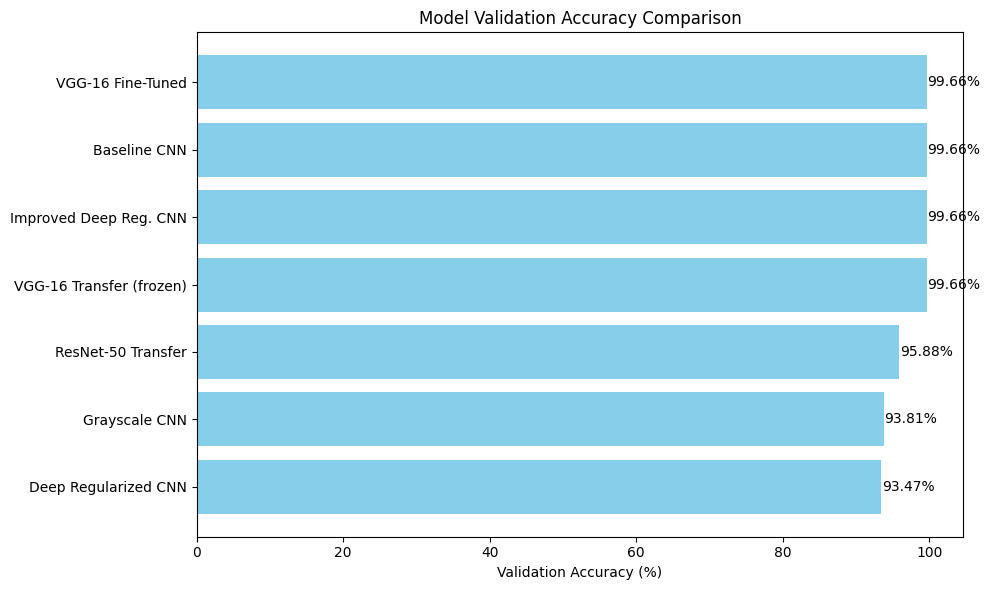

In [16]:
import matplotlib.pyplot as plt

# Model data
models = [
    "VGG-16 Fine-Tuned",
    "Baseline CNN",
    "Improved Deep Reg. CNN",
    "VGG-16 Transfer (frozen)",
    "ResNet-50 Transfer",
    "Grayscale CNN",
    "Deep Regularized CNN"
]

val_accuracy = [99.66, 99.66, 99.66, 99.66, 95.88, 93.81, 93.47]
val_loss = [0.0127, 0.0158, 0.0342, 0.0349, 0.2709, 0.2080, 0.1786]
inference_time = [67.38, 3.21, 4.43, 67.67, 33.13, 4.02, 6.35]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(models, val_accuracy, color='skyblue')
plt.xlabel('Validation Accuracy (%)')
plt.title('Model Validation Accuracy Comparison')
plt.gca().invert_yaxis()  # Highest accuracy on top

# Annotate accuracy values on the bars
for bar, acc in zip(bars, val_accuracy):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', va='center')

plt.tight_layout()
plt.show()


In [17]:
vgg16_finetune_results['model'].save("best_overall_model.keras")


In [18]:
test_loss, test_accuracy = vgg16_finetune_results['model'].evaluate(test_ds_vgg)
print(f"Test Accuracy: {test_accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9881 - loss: 0.0256
Test Accuracy: 0.9880


In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define function to load and preprocess personal images
def load_personal_images(folder_path, img_size=224):
    """
    Load and preprocess personal images for prediction
    
    Args:
        folder_path: Path to folder containing images
        img_size: Size to resize images to (required by VGG16)
        
    Returns:
        images: List of preprocessed images
        file_names: List of file names corresponding to images
    """
    images = []
    file_names = []
    
    # List all files in the directory
    files = os.listdir(folder_path)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(image_files)} images in {folder_path}")
    
    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)
        
        # Load image
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Convert to tensor and normalize (0-1)
        img_tensor = img_array / 255.0
        
        images.append(img_tensor)
        file_names.append(file_name)
    
    # Convert list to tensor array
    images = np.array(images)
    
    return images, file_names

Found 6 images in personal_dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


ValueError: num must be an integer with 1 <= num <= 4, not 5

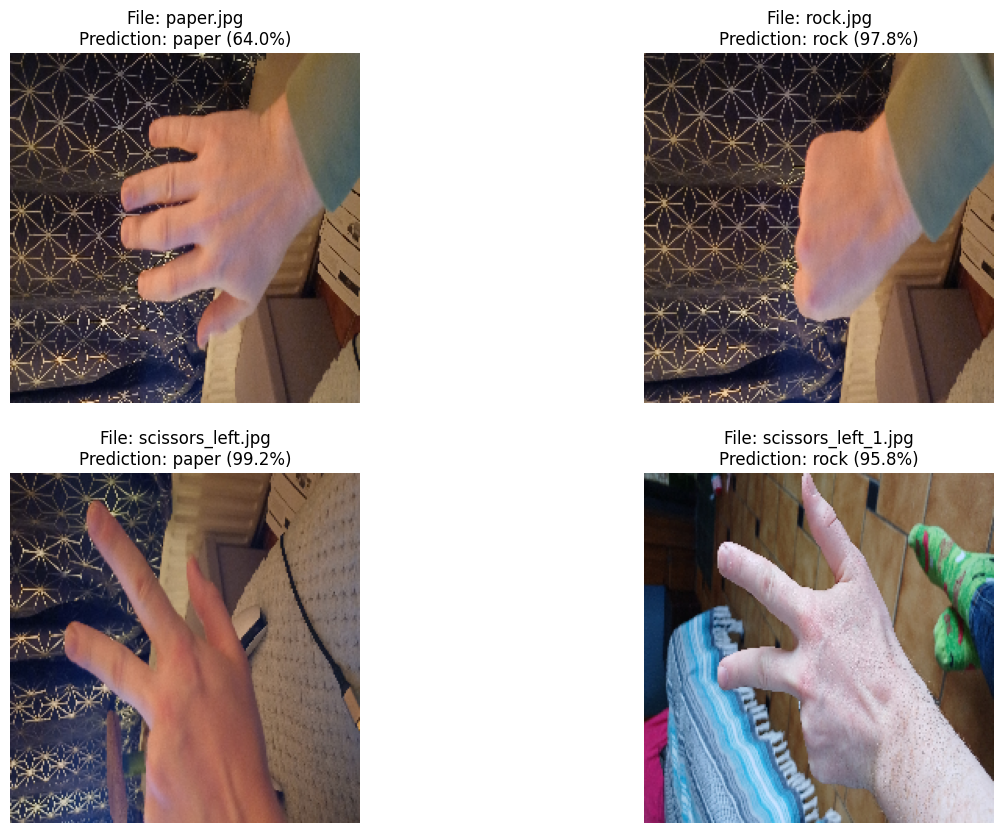

In [ ]:
# Load and test personal images
personal_folder = 'personal_dataset'
personal_images, personal_filenames = load_personal_images(personal_folder, IMG_SIZE_VGG)

# Get the best model (fine-tuned VGG16)
best_model = vgg16_finetune_results['model']

# Predict classes
predictions = best_model.predict(personal_images)
predicted_classes = np.argmax(predictions, axis=1)

# Convert class indices to class names
predicted_labels = [class_names[idx] for idx in predicted_classes]

# Calculate grid dimensions based on number of images
n_images = len(personal_images)
n_cols = min(4, n_images)  # At most 4 columns
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

# Display images with predictions
plt.figure(figsize=(4*n_cols, 4*n_rows))
for i, (img, file_name, pred_label) in enumerate(zip(personal_images, personal_filenames, predicted_labels)):
    if i < n_rows * n_cols:  # Ensure we don't exceed the grid
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        confidence = np.max(predictions[i]) * 100
        plt.title(f"File: {file_name}\nPrediction: {pred_label} ({confidence:.1f}%)")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Personal Rock-Paper-Scissors Test", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Print a summary of results
print("\n=== Personal Image Test Results ===")
print(f"Total images tested: {len(personal_images)}")
for i, (file_name, pred_label) in enumerate(zip(personal_filenames, predicted_labels)):
    confidence = np.max(predictions[i]) * 100
    print(f"Image {i+1}: {file_name} → Predicted as {pred_label} with {confidence:.2f}% confidence")